In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])



In [83]:
basepath = Path("/scratch/crobin/earthnet2023_preprocessed/")
train_paths = list(basepath.glob("train/*/*.nc"))
test_paths = list(basepath.glob("test/*/*.nc"))
pred_paths = list(Path("/Net/Groups/BGI/scratch/crobin/earthnet-models-pytorch/experiments/en23/convlstm_ae/convlstm_ae/config_lr_1e-6/preds/iid/").glob("*/*"))
print("len train set: ", len(train_paths))
print("len test set: ", len(test_paths))
print("len prediction set: ", len(pred_paths))

len train set:  30499
len test set:  3193
len prediction set:  210


In [7]:
pred_path = pred_paths[6]
print(pred_path)
name = str(pred_path)[-12:]
test_path = list(basepath.glob("test/*/" + name))[0]

IndexError: list index out of range

In [90]:
filepath = test_paths[1] #Path('/scratch/crobin/earthnet2023_preprocessed/test/Angola/32KRG5576.nc')
minicube = xr.open_dataset(filepath)
targ = minicube.cop_dem.values.ndim


In [92]:
variables = {
    # Sentinel 2 bands. Spatio-temporal data. Every 5 days.
    "s2_bands": ["s2_B02", "s2_B03", "s2_B04", "s2_B05", "s2_B06", "s2_B07", "s2_B8A"],
    "s2_avail": ["s2_avail"],
    "s2_scene_classification": ["s2_SCL"],
    "cloud_mask": ["s2_mask"],
    # Sentinel 1 bands. Spatio-temporal data. Every 12 days.
    "s1_bands": ["s1_vv", "s1_vh"],
    "s1_avail": ["s1_avail"],
    # Monthly mean and std computed over 1984-2020 using Landsat 5, 7, 8. Digital Earth Africa product.
    "ndviclim": ["ndviclim_mean", "ndviclim_std"],
    # Era5 reanalysis dataset. Era5 era5land pev and pet have a low precision
    "era5lands": [
        "era5land_t2m_mean",
        "era5land_pev_mean",
        "era5land_slhf_mean",
        "era5land_ssr_mean",
        "era5land_sp_mean",
        "era5land_sshf_mean",
        "era5land_e_mean",
        "era5land_tp_mean",
        "era5land_t2m_min",
        "era5land_pev_min",
        "era5land_slhf_min",
        "era5land_ssr_min",
        "era5land_sp_min",
        "era5land_sshf_min",
        "era5land_e_min",
        "era5land_tp_min",
        "era5land_t2m_max",
        "era5land_pev_max",
        "era5land_slhf_max",
        "era5land_ssr_max",
        "era5land_sp_max",
        "era5land_sshf_max",
        "era5land_e_max",
        "era5land_tp_max",
    ],
    # Era5 recomputed by Fabian Gans for the XAIDA project. More accurate.
    "era5": [
        "era5_e",
        "era5_pet",
        "era5_pev",
        "era5_ssrd",
        "era5_t2m",
        "era5_t2mmax",
        "era5_t2mmin",
        "era5_tp",
    ],
    # soigrids is not yet define on 128 x 128 pixels. Can maybe not be used during the prediction period.
    "soilgrids": [
        "sg_bdod_top_mean",
        "sg_bdod_sub_mean",
        "sg_cec_top_mean",
        "sg_cec_sub_mean",
        "sg_cfvo_top_mean",
        "sg_cfvo_sub_mean",
        "sg_clay_top_mean",
        "sg_clay_sub_mean",
        "sg_nitrogen_top_mean",
        "sg_nitrogen_sub_mean",
        "sg_phh2o_top_mean",
        "sg_phh2o_sub_mean",
        "sg_ocd_top_mean",
        "sg_ocd_sub_mean",
        "sg_sand_top_mean",
        "sg_sand_sub_mean",
        "sg_silt_top_mean",
        "sg_silt_sub_mean",
        "sg_soc_top_mean",
        "sg_soc_sub_mean",
    ],
    # Elevation map. Defined on 0 - 2000.
    "elevation": ["cop_dem"],  # ['srtm_dem', 'alos_dem', 'cop_dem'],
    # Landscape classes. Categorical variable.
    "landcover": ["esawc_lc"],
    # Geomorphon classes. Categorical variable. geomorphon is not define on 128 x 128 pixels neither.
    "geomorphon": ["geom_cls"],
}

In [100]:
import torch
# Open the minicube
type = np.float16
minicube = xr.open_dataset(filepath)
targ = (minicube.s2_B8A - minicube.s2_B04) / (
                minicube.s2_B8A + minicube.s2_B04 + 1e-6
            )
# Select the days with available data
indexes_avail = np.where(minicube.s2_avail.values == 1)[0]
# s2 is every 5 days
time = [minicube.time.values[i] for i in range(4, 450, 5)]
dates = [minicube.time.values[i] for i in (indexes_avail)]

# Condition to check that the every 5 days inclus all the dates available (+ missing day)
if not set(dates) <= set(time):
    raise AssertionError("ERROR: time indexes of the minicubes are not consistant ", filepath)

# Create the minicube
# s2 is 10 to 5 days, and already rescaled [0, 1]
s2_cube = (
    minicube[variables["s2_bands"]]
    .to_array()
    .sel(time=time)
    .values.transpose((1, 0, 2, 3))
    .astype(type)[:, :, :128, :128]
)  # shape: (time, channels, w, h)

s2_mask = (
    minicube[variables["cloud_mask"]]
    .to_array()
    .sel(time=time)
    .values.transpose((1, 0, 2, 3))
    .astype(type)[:, :, :128, :128]
)  # (time, 1, w, h)

target = (
    targ
    .sel(time=time)
    .values[:, None, ...]
    .astype(type)[:, :, :128, :128]
)

# weather is daily
meteo_cube = minicube[variables["era5"]]

# rescale temperature on the extreme values ever observed in Africa (Kelvin).
meteo_cube["era5_t2m"] = (meteo_cube["era5_t2m"] - 248) / (328 - 248)
meteo_cube["era5_t2mmin"] = (meteo_cube["era5_t2mmin"] - 248) / (328 - 248)
meteo_cube["era5_t2mmax"] = (meteo_cube["era5_t2mmax"] - 248) / (328 - 248)

meteo_cube = meteo_cube.to_array().values.transpose((1, 0)).astype(type)
meteo_cube[np.isnan(meteo_cube)] = 0

# TODO NaN values are replaces by the mean of each variable.
# col_mean = np.nanmean(meteo_cube, axis=0)
# inds = np.where(np.isnan(meteo_cube))
# meteo_cube[inds] = np.take(col_mean, inds[1])

topography = (
    minicube[variables["elevation"]].to_array() / 2000
)  # c h w, rescaling

# TODO  [:, :128, :128] and mean to remove?
topography = topography.values.astype(type)[:, :128, :128]
topography[np.isnan(topography)] = np.mean(
    topography
)  # idk if we can have missing value in the topography

landcover = (
    minicube[variables["landcover"]]
    .to_array()
    .values.astype(type)[:, :128, :128]
)  # c h w

# TODO transform landcover in categoritcal variables if used for training

# TODO to remove?
# NaN values handling
s2_cube = np.where(np.isnan(s2_cube), np.zeros(1).astype(type), s2_cube)
target = np.where(np.isnan(target), np.zeros(1).astype(type), target)
meteo_cube = np.where(
    np.isnan(meteo_cube), np.zeros(1).astype(type), meteo_cube
)
topography = np.where(
    np.isnan(topography), np.zeros(1).astype(type), topography
)
landcover = np.where(
    np.isnan(landcover), np.zeros(1).astype(type), landcover
)
satellite_data = np.concatenate((target, s2_cube), axis=1)


# Final minicube
data = {
    "dynamic": [
        np.expand_dims(satellite_data, axis=0), #.unsqueeze(0),
            np.expand_dims(meteo_cube, axis=0) #.unsqueeze(0)
        ,
    ],
    "dynamic_mask": [np.expand_dims(s2_mask, axis=0)],
    "static": [np.expand_dims(topography, axis=0)],
    # "target": torch.from_numpy(target),
    # "s2_avail": torch.from_numpy(s2_avail),
    "landcover": np.expand_dims(landcover, axis=0),
    "filepath": str(filepath),
}

(90,)


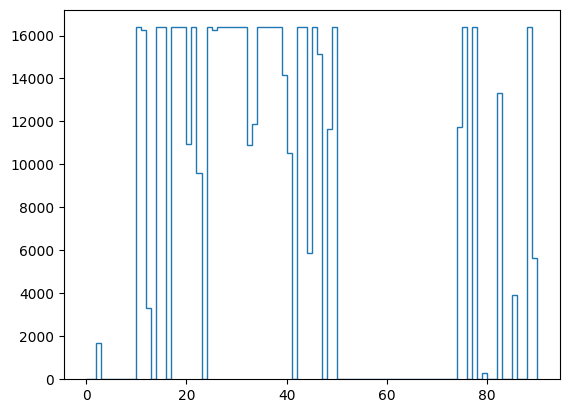

In [101]:
# Transform 
mask = s2_mask[:,0,...]
mask[mask >= 1] = np.nan

# Computation of the NaN values
series_nan  = np.sum(np.isnan(mask), axis=(1,2))
print(series_nan.shape)
plt.stairs(series_nan)
plt.show()

In [103]:
sentinel = data["dynamic"][0]
weather = np.expand_dims(data["dynamic"][1], axis=(3,4))

static = data["static"][0] if data["static"][0].ndim == 4 else data["static"][0][... ,0]

# Shape: batch size, temporal size, number of channels, height, width
b, t, _, h, w = sentinel.shape

# initialize hidden states
context_length = 60
skip_connections = True
target_length = 30

output = []

# Encoding network
for t in range(context_length):
    input = torch.cat((sentinel[:, t, ...], static), dim=1)
    # WARNING only for En23
    weather_t = (
        weather[:, t : t + 5, ...]
        .view(weather.shape[0], 1, -1, 1, 1)
        .repeat(1, 1, 128, 128)
    )
    input = torch.cat((input, weather_t), dim=1)
    # First block
    pred = sentinel[:, t, ...]

# add the last frame of the context period
if skip_connections:
    pred = pred + sentinel[:, -1, 0, ...].unsqueeze(1)



# forecasting network
for t in range(target_length):
    # if teacher_forcing:
    #    pred = target[:, c_l + t, ...]

    # Skip connection
    pred_previous = torch.clone(pred)

    # Input
    weather_t = (
        weather[:, context_length + t : context_length + t + 5, ...]
        .view(weather.shape[0], 1, -1, 1, 1)
        .squeeze(1)
        .repeat(1, 1, 128, 128)
    )
    pred = torch.cat((pred, static), dim=1)
    pred = torch.cat((pred, weather_t), dim=1)

    if skip_connections:
        pred = pred + pred_previous

    # Output

    output += [pred.unsqueeze(1)]
output = torch.cat(output, dim=1)  # .unsqueeze(2)


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

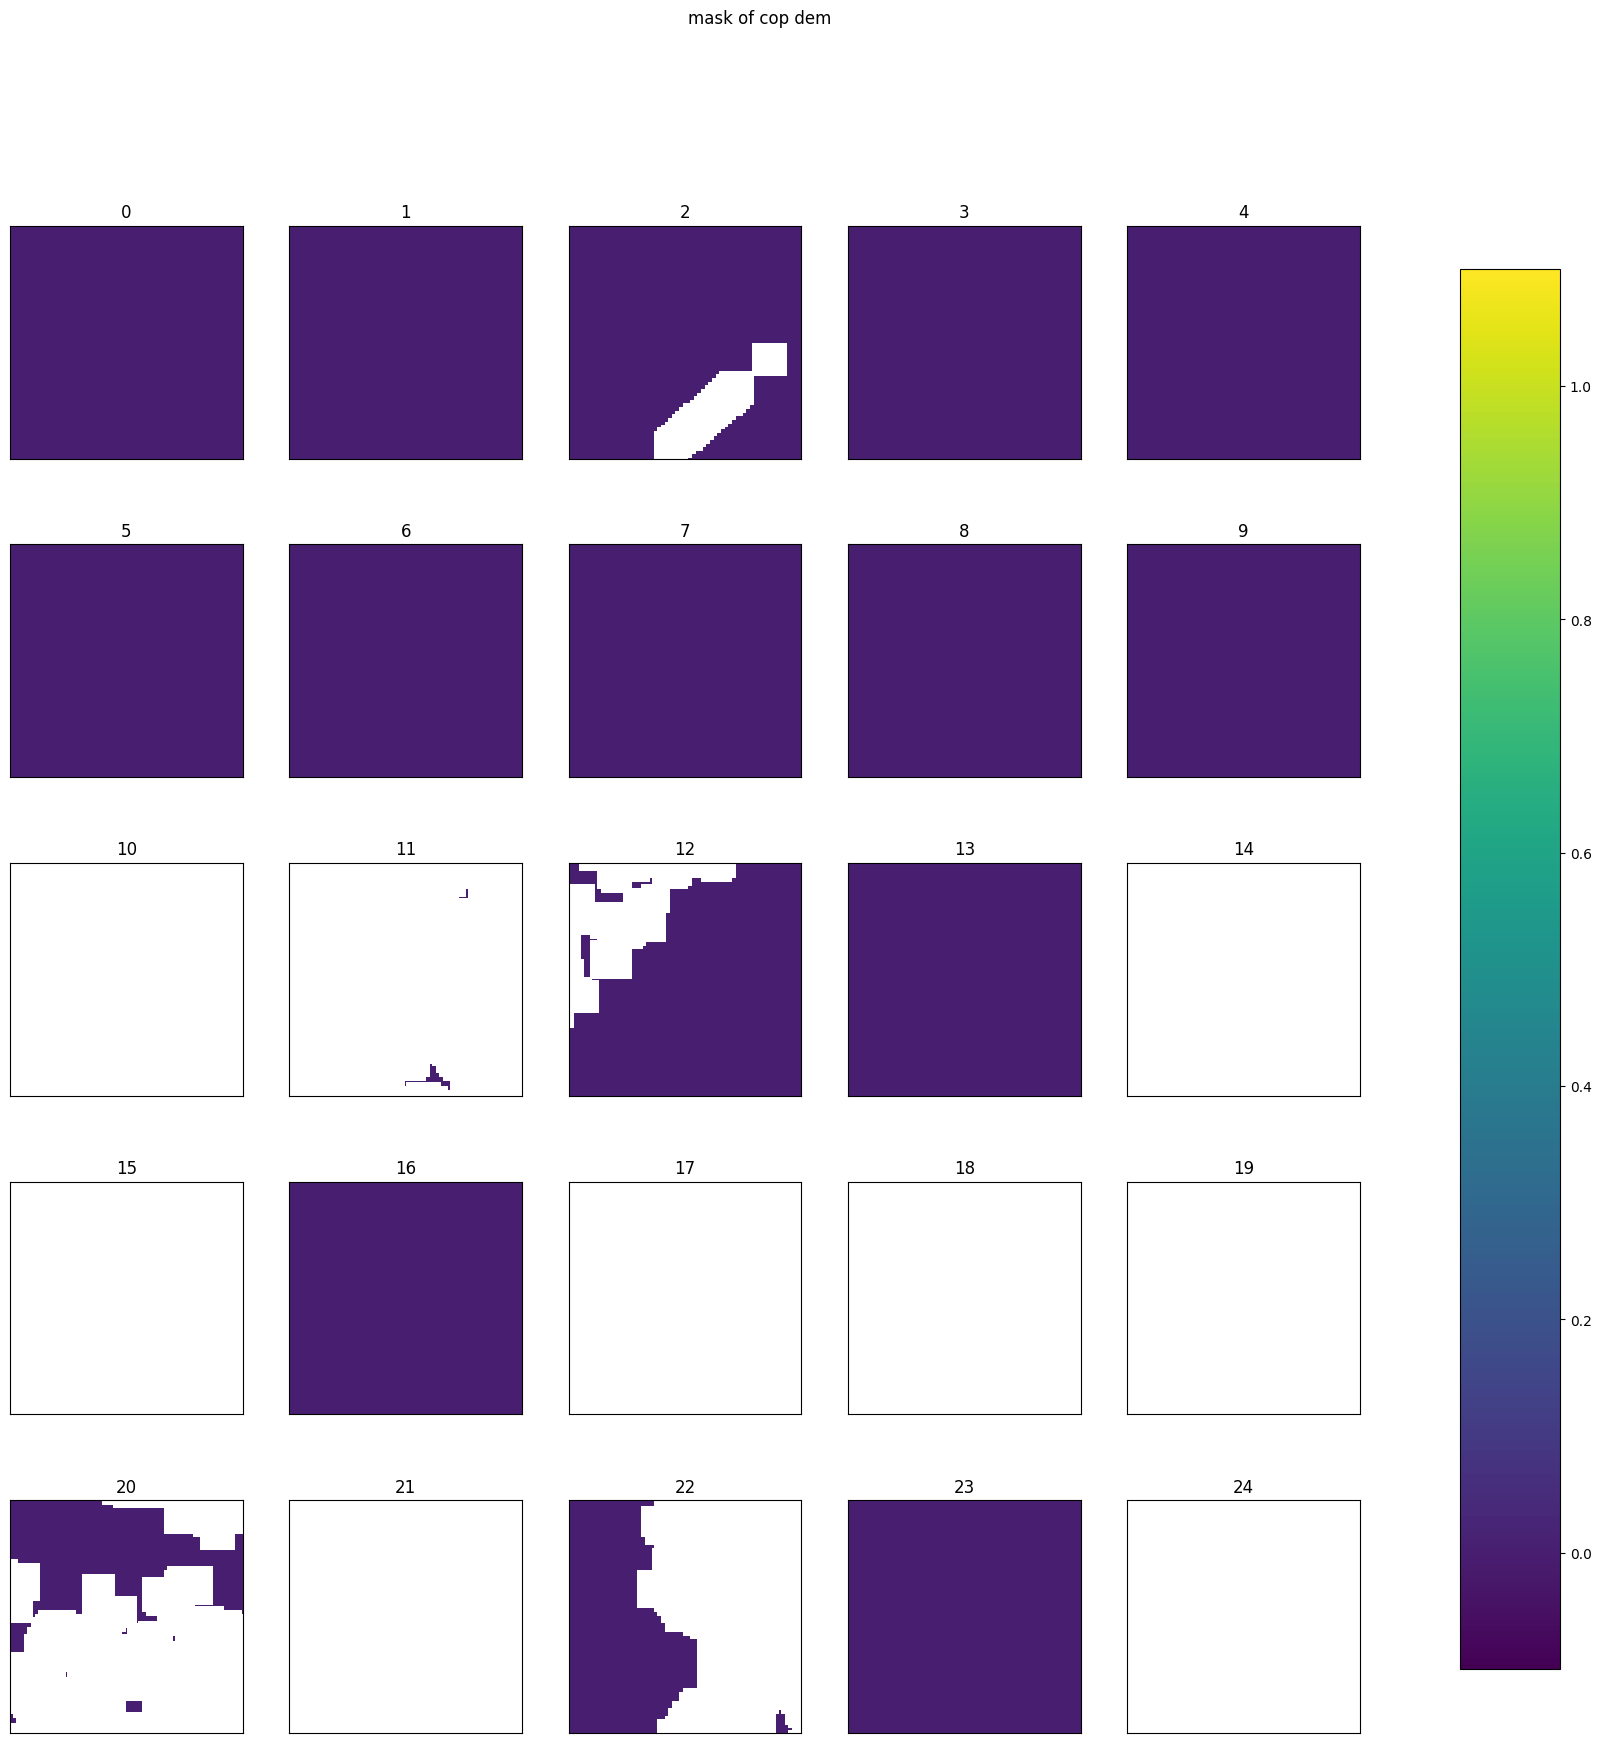

In [88]:

target = data["dynamic_mask"][0][:,0,...]
cmap = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

name = "cop dem"
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
fig.suptitle("mask of " + name)
t= 0
for i in range(5):
    for j in range(5):
        #axes[i,j].set_aspect(1)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].set_title(t)
        im = axes[i,j].imshow(target[t], vmin=-0.1, vmax=1.1)
        #im = targ.isel(time=time[t]).plot(cmap=cmap_veg, ax=axes[i,j])
        t += 1 # non gap filled, a lot of nan values

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)